# Exploring Sonoma County animal shelter intake and outcome data 
## Data source
For this data analysis, we are using the Sonoma County Animal Shelter Intake and Outcome dataset collected and made publicly available by Sonoma County with the purpose of helping the community better understand the animals being cared for by the shelter.

The dataset includes each animal’s name, type, breed, color, sex, size, date of birth, kennel/impound details and ID, intake/outcome date, days in shelter, intake/outcome types, health condition, and outcome location. The data spans from August 2013 to May 2023.
## Questions we seek to answer
- What types of animals are cared for by the shelter?
- Has the number of intakes increased or decreased over time?
- During which month does the shelter have the most intakes?
- What are the most common outcomes?
- During which month does the shelter have the most adoptions?
- Does age affect the likelihood of an animal's adoption?
- Is age a factor in how long an animal stays at the shelter?
- Is gender a factor in how long an animal stays at the shelter?

## Importing needed libraries/modules and reading the data from the CSV

In [1]:
# Importing needed libraries/modules
from pandas import read_csv, to_datetime, Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.dates as mdates
import gmplot
import project_functions
import seaborn as sns

# Open data file
df = read_csv('intake_and_outcome_data.csv')

## Cleaning/converting the name; birth, intake, and outcome date; and outcome type columns

In [2]:
# Replacing all NaN values of name column with "No name"
df["Name"].fillna("No name", inplace=True)

# Converts string dates to datetime dtypes
df["Date Of Birth"] = to_datetime(df["Date Of Birth"])
df["Intake Date"] = to_datetime(df["Intake Date"])
df["Outcome Date"] = to_datetime(df["Outcome Date"])

df["Outcome Type"].fillna("Pending", inplace=True)
df["Outcome Type"].replace("RTOS", "RETURN TO OWNER", inplace=True)

### Calculating age and adding Age In Days column

In [3]:
# Find age in days of animal on intake date if birth date provided
birth_dates = np.array(df["Date Of Birth"], dtype='datetime64[D]')
intake_dates = np.array(df["Intake Date"], dtype='datetime64[D]')
ages = np.array((intake_dates - birth_dates), dtype="int")
ages = np.where(ages < 0, 0, ages) # changes age to zero if born after intake
ages = np.where(np.isnat(birth_dates), np.nan, ages) # gives NaN value if no birthday provided and changes dtype to float64
df['Age In Days'] = ages

# Calculate average age of animals excluding those with unknown birth dates
avg_age_in_years = np.nanmean(project_functions.convertAgeToYears(ages))
print(avg_age_in_years)

3.432420600428609


## Animal types

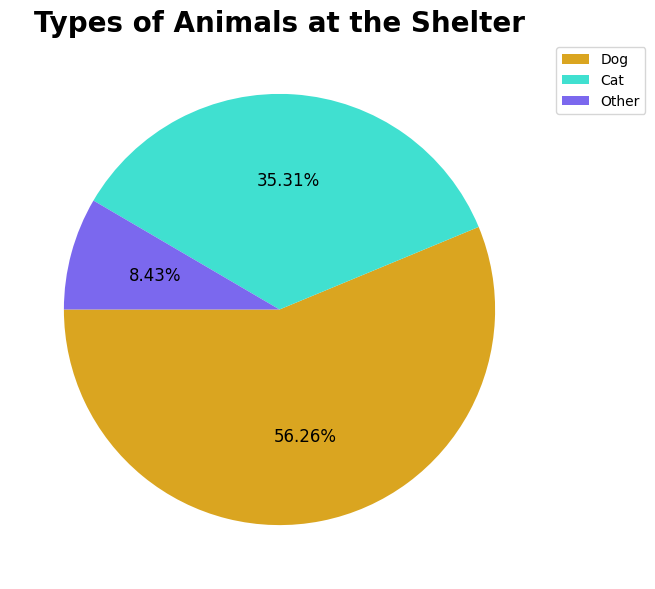

In [4]:
animal_types = df["Type"].value_counts()
project_functions.type_pie_chart(animal_types, "Types of Animals at the Shelter")

## Animal intakes
### Animal intakes per month
To better see the data for each year, we can plot monthly intakes for the years included in the data set (2013-2023) based on user input. To do this, we create a pandas dataframe based on the inputted year and use dt.month.value_counts() to get a count of each month in the dataframe. We then plot this information on a bar graph.

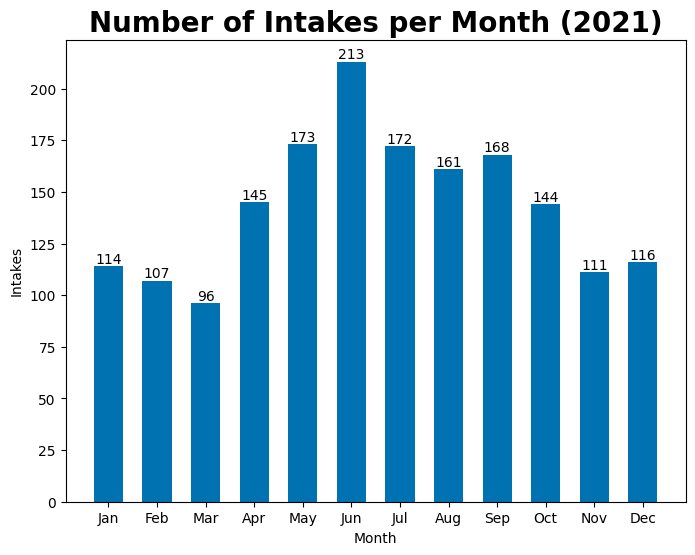

In [5]:
# Find number of intakes by month for specific year
year, df_in_date = project_functions.requestIntakeDateYearInput(df)
total_annual_intakes = len(df_in_date.index)
monthly_intakes = Series.sort_index(df_in_date["Intake Date"].
                                    dt.month.value_counts())

# Plot monthly intakes
project_functions.monthly_in_out(monthly_intakes, year, "Intakes")

### Average animal intakes per month
We also wanted to find out how many intakes the shelter has on average for each month of the year. We use dt.month.value_counts() to get a count of the total number of intakes for each month for all years. To find the average of each month, we divide the total intakes for each month by the number of years in the dataset.

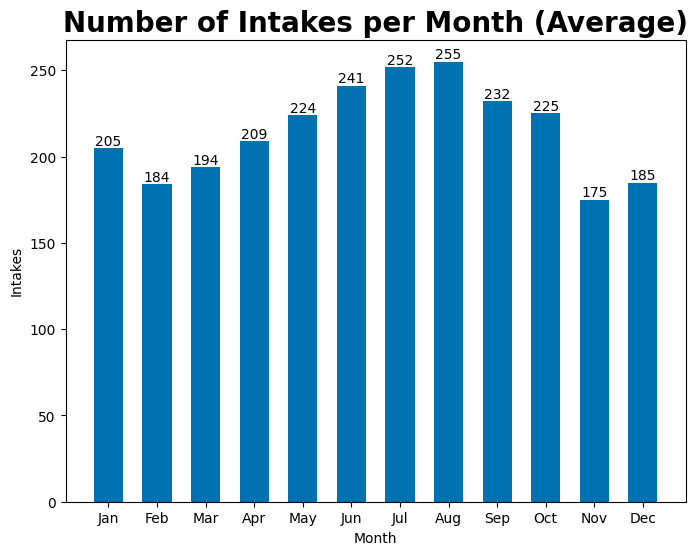

In [6]:
# Find average number of intakes for each month
all_monthly_intakes = (Series.sort_index(df["Intake Date"].dt.month.value_counts())).to_numpy() 
num_of_years = round((df["Intake Date"].max()-df["Intake Date"].min())/np.timedelta64(1, 'Y'), 2)
avg_monthly_intakes = Series((all_monthly_intakes/num_of_years).round(decimals=0), index=[x for x in range(1, 13)])

project_functions.monthly_in_out(avg_monthly_intakes, "Average", "Intakes")

## Outcomes
### Outcomes per month
Note: There were no outcomes listed for 2013.

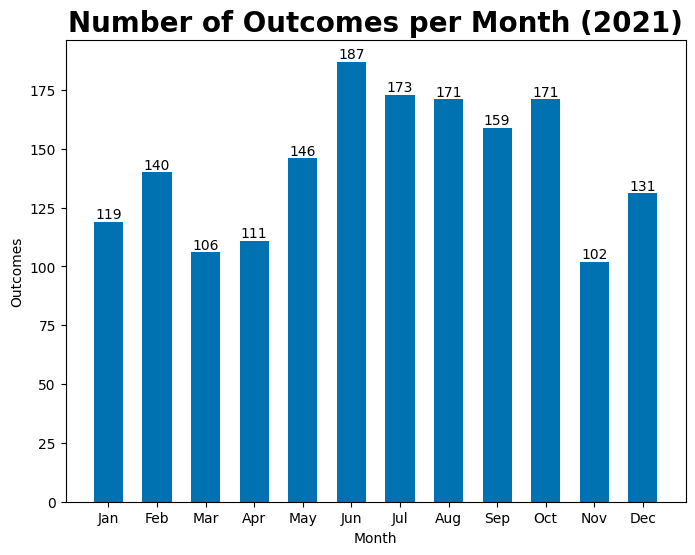

In [7]:
# Find number of outcomes by month for specific year
year, df_out_date = project_functions.requestOuttakeDateYearInput(df)
df_out_date = df[df["Outcome Date"].dt.strftime("%Y") == f"{year}"]
total_annual_outcomes = len(df_out_date.index)
monthly_outcomes = Series.sort_index(df_out_date["Outcome Date"].
                                     dt.month.value_counts())
# Plot monthly outcomes
project_functions.monthly_in_out(monthly_outcomes, year, "Outcomes")

### Outcome types


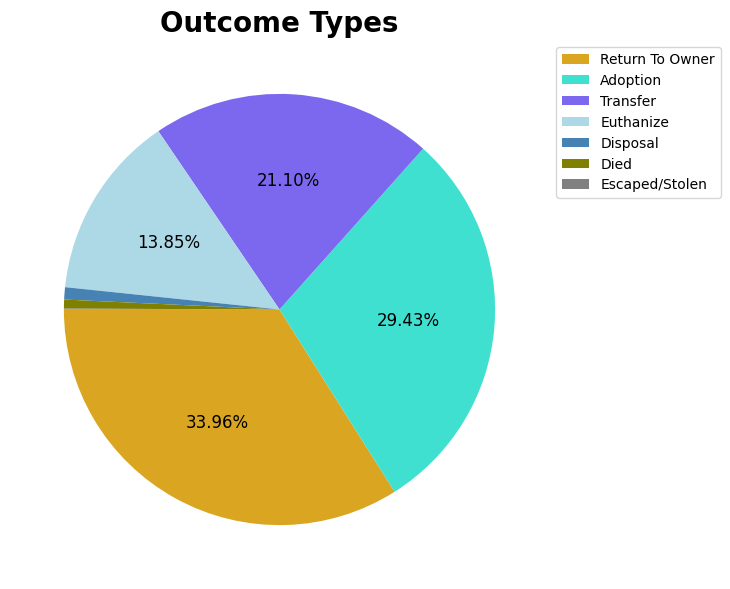

In [8]:
# Plot outcome types
outcomes = df["Outcome Type"].mask(df["Outcome Type"] == "Pending").value_counts()
project_functions.type_pie_chart(outcomes, "Outcome Types")

## Animal adoption rate


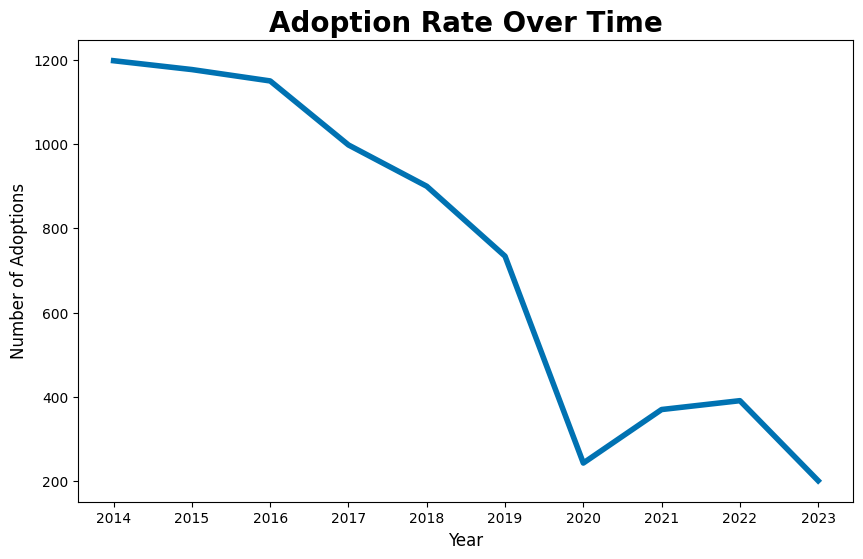

In [9]:
adoptions = df[["Outcome Date", "Outcome Type"]].mask(df["Outcome Type"] != "ADOPTION", inplace=False)
yearly_adoptions =  Series.sort_index(adoptions["Outcome Date"].dt.year.value_counts())

plt.figure(figsize=(10, 6))
plt.plot(yearly_adoptions, linewidth=4)
plt.title("Adoption Rate Over Time", size=20, weight="bold")
plt.xticks(yearly_adoptions.index.values)
plt.ylabel("Number of Adoptions", size=12)
plt.xlabel("Year", size=12)
plt.show()

### Animal adoptions versus intakes and all outcomes

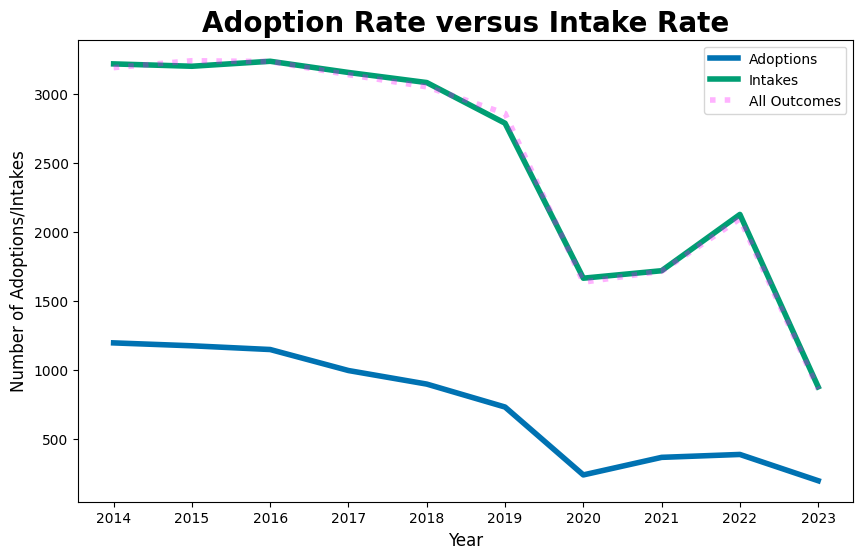

In [10]:
# Plot intakes/adoptions over time 
yearly_intakes =  Series.sort_index(df["Intake Date"].dt.year.value_counts())
yearly_outcomes =  Series.sort_index(df["Outcome Date"].dt.year.value_counts())
plt.figure(figsize=(10, 6))
plt.plot(yearly_adoptions, label="Adoptions", linewidth=4)
plt.plot(yearly_intakes[1:], label="Intakes", linewidth=4)
plt.plot(yearly_outcomes, label="All Outcomes", alpha=0.3, color="magenta", linestyle=":", linewidth=4)
plt.xticks(yearly_adoptions.index.values)
plt.title("Adoption Rate versus Intake Rate", size=20, weight="bold")
plt.ylabel("Number of Adoptions/Intakes", size=12)
plt.xlabel("Year", size=12)
plt.legend()
plt.show()

### Age and Length of Stay for Adopted Animals
#### Does the age of the animal influence how long they stay at the shelter before being adopted?

The average age of an animal upon entering the shelter is 3.4 years.
The average age of an animal that gets adopted 1.8 years.
The average length of stay for an animal at the shelter, regardless of outcome, is 18.4 days.
The average length of stay for an animal that gets adopted is 33.8 days.


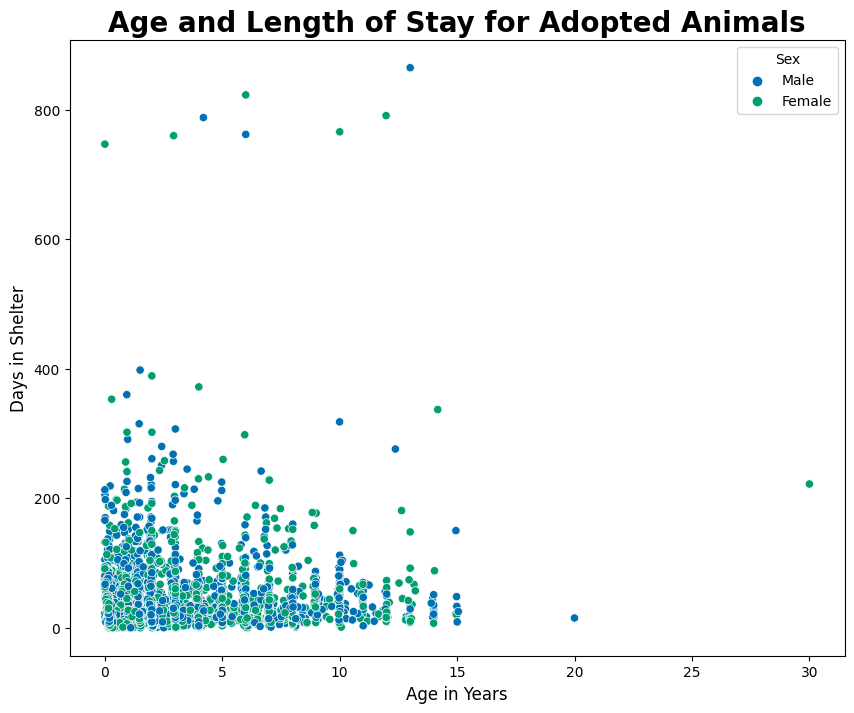

In [11]:
avg_age_in_years = np.nanmean(project_functions.convertAgeToYears(df["Age In Days"]))
avg_age_of_adopted = np.nanmean(project_functions.convertAgeToYears(df["Age In Days"].mask(df["Outcome Type"] != "ADOPTION")))
avg_los = np.nanmean(df["Days in Shelter"])
avg_los_adopted = np.nanmean(df["Days in Shelter"].mask(df["Outcome Type"] != "ADOPTION"))
print(f"The average age of an animal upon entering the shelter is {avg_age_in_years:.2} years.")
print(f"The average age of an animal that gets adopted {avg_age_of_adopted:.2} years.")
print(f"The average length of stay for an animal at the shelter, regardless of outcome, is {avg_los:.3} days.")
print(f"The average length of stay for an animal that gets adopted is {avg_los_adopted:.3} days.")

genders = df["Sex"].mask(df["Sex"] == "Neutered", "Male", inplace=False)
genders = genders.mask(genders == "Spayed", "Female", inplace=False)
genders = genders.where(genders != "Unknown")
plt.figure(figsize=(10,8))
plt.title("Age and Length of Stay for Adopted Animals", size=20, weight="bold")
plt.ylabel("Days in Shelter", size=12)
plt.xlabel("Age in Years", size=12)
sns.scatterplot(x=project_functions.convertAgeToYears(df["Age In Days"].mask(df["Outcome Type"] != "ADOPTION")), y=df["Days in Shelter"].mask(df["Outcome Type"] != "ADOPTION"), hue=genders)
plt.show()

## Finding correlation between gender and days in shelter

Female average days in shelter: 11.997448256308477
Male average days in shelter: 11.865361942937986
Neutered average days in shelter: 23.302294845608554
Spayed average days in shelter: 24.19804721655494
Unknown average days in shelter: 5.058691756272402


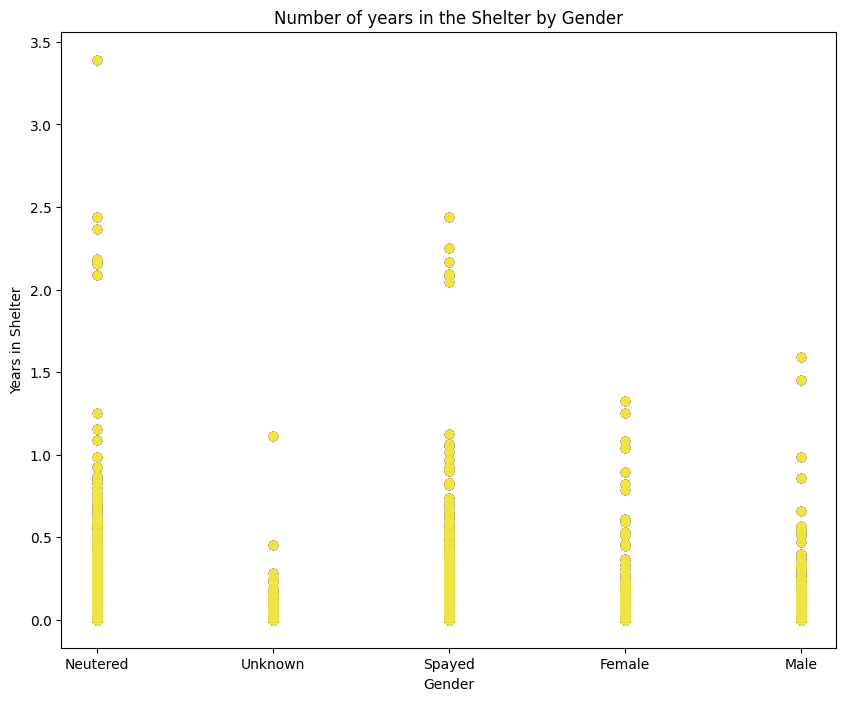

In [12]:
plt.figure(figsize=(10,8))
plt.title("Number of years in the Shelter by Gender")
plt.ylabel("Years in Shelter")
plt.xlabel("Gender")
plotHeight = np.amax(df["Days in Shelter"]) + 1.0

#get unique Gender from dataframe
uniqueGenders = np.unique(df["Sex"])
x_axis = np.arange(len(uniqueGenders))

gender_col = np.array(df.loc[df["Sex"] == "Spayed", "Days in Shelter"])

for gender in uniqueGenders:
    avgGenderDiS = np.average(np.array(df.loc[df["Sex"] == gender,"Days in Shelter"],dtype="float"))
    print(f"{gender} average days in shelter: {avgGenderDiS}")
    plt.scatter(x=df["Sex"],y=project_functions.convertDaysInShelterToYears(df["Days in Shelter"]))

plt.show()

## Mapping animal locations (Jason)

In [13]:

#instantiate a latitude and longitude array
lat_list = []
lng_list = []

#get the Location information that is formatted like "95404(38.43807, -122.71247)"
latlong = np.array(df["Location"], dtype="str")
#massage the data and convert it to float values
for loc in latlong:
    loc = str(loc)
    if '(' in loc:
        loc = loc.split('(')[1].removesuffix(')')
        lat_list.append(float(loc.split(',')[0]))
        lng_list.append(float(loc.split(',')[1]))

#create a default Google Map
gmap=gmplot.GoogleMapPlotter(lat='38.43807',lng='-122.71247', zoom=8)
gmap.apikey = 'xxxxxxxxx'
#create a scatter plot with markers
gmap.scatter(lats=lat_list, lngs=lng_list, size=40, marker=True, color="red")
#save the map to an html file
gmap.draw('map.html')